# A brief introduction to Python for Hydrological Analyses
This is a Jupyter Notebook, a web-based interactive development environment that allows to create and share python codes.
First things first, what is **Python**? Python is an high-level and general-purpose programming language. It can be used to write software in a wide variety of application domains, including hydrology. Python can be used to perform numerical calculations, statistical analyses or to access and plot data (even large datasets). <br>
In Jupyter Notebook the *Python shell* is embedded. The shell is where you can write and execute a line (or multiple lines) of code.
Python is open-source, and several packages are available covering many scientific and technological fields.

Let's start using Python as a **calculator**:

In [1]:
190/3


63.333333333333336

If needed we can assign this result to a variable, and use the variable for further math or for other operations (such as converting to integer and priting it).

In [116]:
result = 190/3
new_result = result - 14
int_result = int(new_result)
print(int(int_result))


49


What if we want to perform some more complex calculus? We can import the **math** package, loading several mathematical functions (such as the square root)

In [117]:
import math
sqrt_result = math.sqrt(int_result)
print(sqrt_result)


7.0


What if we want to work not with a single value, but with a **vector** composed of multiple values?

In [118]:
import numpy as np
array = [1,4,100,3,-2]
print(array)
print('------> complete array maximum: ' + str(np.max(array)))
array_nan = array
array_nan[2] = np.nan
print(array_nan)
print('------> incomplete array maximum: ' + str(np.max(array)))


[1, 4, 100, 3, -2]
------> complete array maximum: 100
[1, 4, nan, 3, -2]
------> incomplete array maximum: nan


Is the last result correct? Shouldn't be 4 the new maximum value? We can use a specific function for accounting for "Nan" or missing values: *np.nanmax* (part of numpy package)

In [119]:
print('------> incomplete array maximum: ' + str(np.nanmax(array)))


------> incomplete array maximum: 4.0


### Dealing with Timeseries
Can we generate **timeseries** (multiple values with associated date) and plot it? Of course!

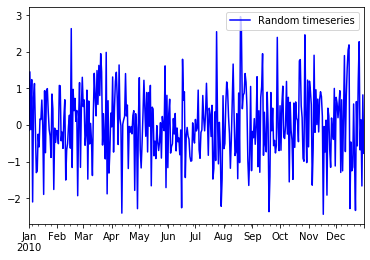

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
ts = pd.Series(np.random.randn(365), index=pd.date_range('1/1/2010', periods=365))
plt.figure()
ts.plot(style='b-', label='Random timeseries')
plt.legend()


Finally, what if we want to read and plot an existing timeseries, available in **csv or txt format** for instance?
At first, let's load the list of the stations available in the environment "meteo" folder:

In [121]:
available_series = pd.read_csv('meteo/coordinates.csv', parse_dates=False, index_col='code')
display(available_series)

,name,lat,lon,available variables
code,,,,
BY000064390,Bujumbura,-3.317,29.317,precipitation
ER000063021,Asmara,15.283,38.917,precipitation temperature
ET000063450,AddisAbabaBole,9.033,38.750,precipitation temperature
KEM00063741,NairobiDagoretti,-1.300,36.750,precipitation temperature
RWM00064387,KigaliInternational,-1.969,30.139,precipitation temperature
SU000062721,Kartoum,15.600,32.549,precipitation temperature
SU000062941,Juba,4.867,31.600,precipitation temperature
TZ000063894,DarEsSalaamAirport,-6.867,39.200,precipitation temperature


Now we can interactively plot one of the available timeseries by choosing the station, the variable and also the time limits: 

,type,val
1957-02-13,TAVG,18.1
1957-02-14,NaN,NaN
1957-02-15,NaN,NaN
1957-02-16,NaN,NaN
1957-02-17,NaN,NaN
...,...,...
2021-06-20,NaN,NaN
2021-06-21,NaN,NaN
2021-06-22,NaN,NaN
2021-06-23,NaN,NaN


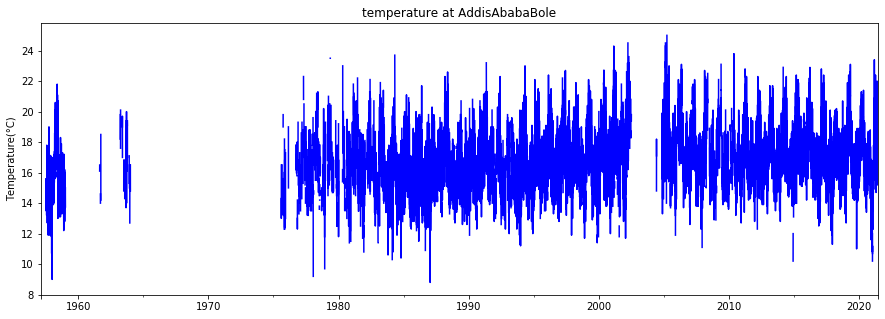

In [139]:
# Please, specify an available station code and variable of interest
section_code =  'ET000063450'
variable = 'temperature'
time_start = None    # Set a date in the format 'YYYY-MM-DD' or None for plot the series from the beginning
time_end = None      # Set a date in the format 'YYYY-MM-DD' or None for plot the series up to the end
####################################################################

# Read data series
dic_vars={'precipitation':['PRCP', 'Rainfall(mm)'], 'temperature':['TAVG','Temperature(°C)']}
temp_series = pd.read_csv('meteo/' + section_code + '.csv', header=0, usecols=[1,2,3], names=['date','type','val'])
temp_series = temp_series[temp_series["type"]==dic_vars[variable][0]]
temp_series['date'] = pd.to_datetime(temp_series['date'], format='%Y%m%d')
temp_series['val'] = temp_series['val']/10
temp_series.set_index('date', inplace=True)

# Set time range
if time_start is None : time_start = min(temp_series.index) 
if time_end is None : time_end = max(temp_series.index)
time_range = pd.date_range(time_start,time_end,freq='1D')
temp_series = temp_series.reindex(time_range)

display(temp_series)

# Manage plot
ax = temp_series.plot(style='b', title=variable + ' at ' + available_series.loc[section_code]['name'], figsize=(15,5))
ax.set_xlabel("")
ax.set_ylabel(dic_vars[variable][1])
ax.get_legend().remove()
plt.show()


Time series can be asily managed with python for resampling and statistical operations:

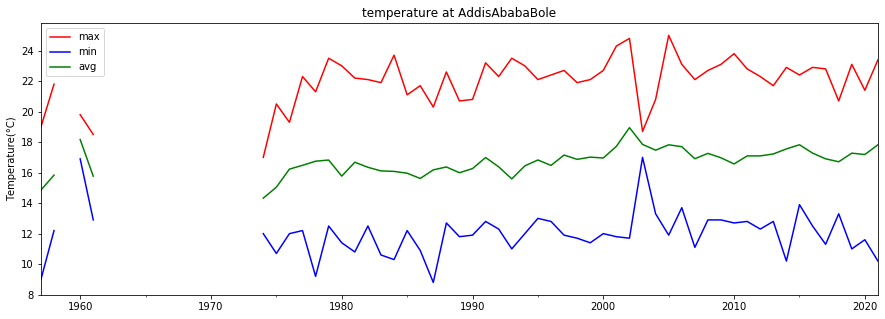

In [125]:
# The resample frequency can be set, e.g., to annual 'Y' or monthly 'M'
temp_resampled_max = temp_series.reindex(time_range).resample('Y').max()
temp_resampled_min = temp_series.reindex(time_range).resample('Y').min()
temp_resampled_avg = temp_series.reindex(time_range).resample('Y').mean()

# Manage plot
ax = temp_resampled_max.plot(style='r', title=variable + ' at ' + available_series.loc[section_code]['name'], figsize=(15,5))
temp_resampled_min.plot(style='b',ax=ax)
temp_resampled_avg.plot(style='g',ax=ax)
ax.set_xlabel("")
ax.set_ylabel(dic_vars[variable][1])
plt.legend(['max','min','avg'])
plt.show()


## Flood frequency analysis using Python
We can use python to compute flood statistics on a discharge timeseries. Reference to *hydro-informatics.github.io* <br>

Occurence of relevant (extreme) flood events can be expressed as **return period**, expressing the average recurrence interval of an event of a certain magnitude in units of time. It is the inverse of the **exceedance probability** (the likelihood of an event of a certain magnitude or higher).<br>
A significant assumption in calculating the return period is that individual events are assumed indipendent. This means that, for any given year, the probability of a 100-year flood occurring is 1/100.
Here below a table showing the recurrence intervals and related probabilities of occurrences.

| Return Period (years) | Annual exceeding probability (%) |
| --- | --- |
| 2 | 50 |
| 5 | 10 |
| 10 | 10 |
| 50 | 2 |
| 100 | 1 |
| 500 | 0.2 |

First things firt, we should import the **discharge data**. 
Let's see what "txt" series files can be find inside the "discharge" folder:

In [214]:
import glob
files = glob.glob("discharge/*.txt")
print(files)

['discharge/1577100_Q_Day.Cmd.txt', 'discharge/1577050_Q_Day.Cmd.txt', 'discharge/1577600_Q_Day.Cmd.txt', 'discharge/1577601_Q_Day.Cmd.txt', 'discharge/1577602_Q_Day.Cmd.txt', 'discharge/1577102_Q_Day.Cmd.txt', 'discharge/1577300_Q_Day.Cmd.txt', 'discharge/1577603_Q_Day.Cmd.txt', 'discharge/1577101_Q_Day.Cmd.txt', 'discharge/1577800_Q_Day.Cmd.txt', 'discharge/1577500_Q_Day.Cmd.txt', 'discharge/1577700_Q_Day.Cmd.txt', 'discharge/1577200_Q_Day.Cmd.txt']


The list don't tell us much abouyt the file content, we can open one of them to understand the content of each file **NOTE! Python numbering starts from 0!!**:

In [215]:
number_of_lines = 40

with open(files[0],'rb') as file:
    for i in np.arange(0,number_of_lines,1): 
        line = file.readline().decode('ISO-8859-1')
        print(str(i) + ' ' + line)
        
#available_series = pd.read_csv('meteo/coordinates.csv', parse_dates=False, index_col='code')
#display(available_series)

0 # Title:                 GRDC STATION DATA FILE

1 #                        --------------

2 # Format:                DOS-ASCII

3 # Field delimiter:       ;

4 # missing values are indicated by -999.000

5 #

6 # file generation date:  2021-06-28

7 #

8 # GRDC-No.:              1577100

9 # River:                 AWASH WENZ

10 # Station:               MELKA KUNTIRE

11 # Country:               ET

12 # Latitude (DD):       8.7

13 # Longitude (DD):      38.6

14 # Catchment area (km²):      4456.0

15 # Altitude (m ASL):        1850.0

16 # Next downstream station:      1577101

17 # Remarks:               

18 # Owner of original data: Ethiopia - Ministry of Water Resources, Hydrology Department

19 #************************************************************

20 #

21 # Data Set Content:      MEAN DAILY DISCHARGE (Q)

22 #                        --------------------

23 # Unit of measure:                  m³/s

24 # Time series:           1978-01 - 2008-12

25 # No. of years: 

The lines between 8 and 18 of each file contains all the information about the station, we can use python capability of manage different file type to summarize those information in a table:

In [216]:
# Read the 11 lines after line 8 (Python numbering starts from 0!)
for ind, file in enumerate(files,0):
    data = pd.read_csv(file, skiprows=8, nrows=11, sep=":", encoding='ISO-8859-1', header=None, names=['cod','val'])    
    if ind == 0:
        list_vars = [i.replace('# ','') for i in data['cod']]
        df_stations = pd.DataFrame(index=np.arange(0,len(files),1),columns=list_vars)
    data['cod'] = list_vars
    data = data.set_index(['cod'])
    for var in list_vars:
        df_stations.loc[ind][var] = data.loc[var].values[0].strip()

df_stations = df_stations.set_index(["GRDC-No."])
display(df_stations)

,River,Station,Country,Latitude (DD),Longitude (DD),Catchment area (km²),Altitude (m ASL),Next downstream station,Remarks,Owner of original data
GRDC-No.,,,,,,,,,,
1577100,AWASH WENZ,MELKA KUNTIRE,ET,8.7,38.6,4456.0,1850.0,1577101,,"Ethiopia - Ministry of Water Resources, Hydrol..."
1577050,HOLETA SHET',NEAR HOLETTA,ET,9.08,38.52,119.0,1860.0,1577600,,Initial dataset collected in the framework of ...
1577600,AWASH WENZ,AWASH,ET,9.2,40.2,18710.0,-999.00,1577601,,Initial dataset collected in the framework of ...
1577601,AWASH WENZ,MELKA SEDI,ET,9.39,40.13,21520.0,-999.00,1577602,,"Ethiopia - Ministry of Water Resources, Hydrol..."
1577602,AWASH WENZ,ADAITU,ET,11.133333,40.783333,52835.0,-999.00,1577603,,"Ethiopia - Ministry of Water Resources, Hydrol..."
1577102,AWASH WENZ,METAHARA,ET,8.85,39.85,16416.0,-999.00,1577600,,"Ethiopia - Ministry of Water Resources, Hydrol..."
1577300,K'ELET'A WENZ,SIRE VILLAGE,ET,8.27,39.4,745.0,1560.0,1577102,,Initial dataset collected in the framework of ...
1577603,AWASH WENZ,TENDAHO,ET,11.683333,40.95,62088.0,-999.00,-,,"Ethiopia - Ministry of Water Resources, Hydrol..."
1577101,AWASH WENZ,HOMBOLE,ET,8.383333,38.783333,7656.0,-999.00,1577102,,"Ethiopia - Ministry of Water Resources, Hydrol..."


We can now choose which station to analyse by providing its code to identify the related file, let's start, for example, with the **AWASH WENZ at MELKA KUNTIRE**:

Text(0, 0.5, 'Q (m3/s)')

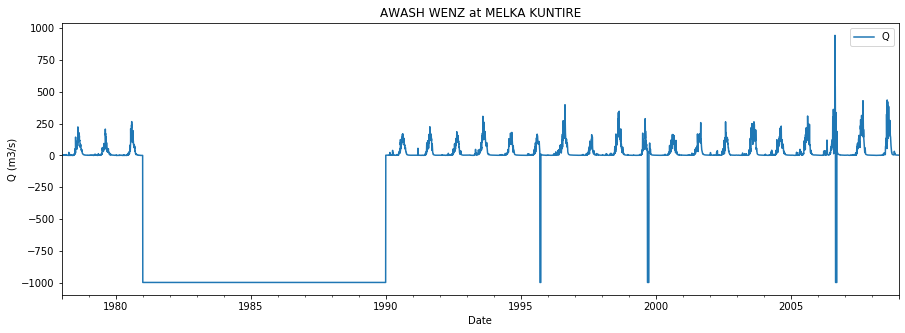

In [227]:
# Please, specify an available station code
station_code = '1577100'
##############################################################################################

# Read data from line 37
df = pd.read_csv("discharge/" + station_code + "_Q_Day.Cmd.txt",
                 header=None,
                 sep=";",
                 skiprows=37,
                 names=["Date", "Time","Q"],
                 parse_dates=[0],
                 index_col=["Date"])
df['Q']=df['Q'].astype(float)
ax = df.plot(title=df_stations.loc[station_code]["River"] + " at " + df_stations.loc[station_code]["Station"], figsize=(15,5))
ax.set_ylabel('Q (m3/s)')

There are null values in the series, that corresponds to null values, we can mange them by repalacing with "np.nan" that is the standard numpy null value:

Text(0, 0.5, 'Q (m3/s)')

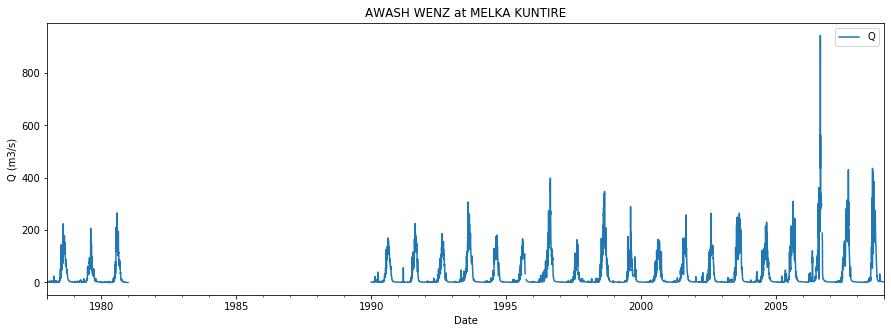

In [228]:
# Replace negative values with "null"
df.loc[df['Q']<0,'Q']=np.nan
ax = df.plot(title=df_stations.loc[station_code]["River"] + " at " + df_stations.loc[station_code]["Station"], figsize=(15,5))
ax.set_ylabel('Q (m3/s)')

This is the complete timeseries: we have to select only the **yearly maxima**. It is quite straightforward with *pandas dataframe*, we can resample our dataset (which has been indexed with dates).


     Time        Q  year
0   --:--  224.000  1978
1   --:--  207.000  1979
2   --:--  266.000  1980
12  --:--  169.851  1990
13  --:--  225.398  1991
14  --:--  186.504  1992
15  --:--  307.421  1993
16  --:--  180.862  1994
17  --:--  167.155  1995
18  --:--  398.626  1996
19  --:--  163.154  1997
20  --:--  347.518  1998
21  --:--  289.232  1999
22  --:--  164.060  2000
23  --:--  258.119  2001
24  --:--  264.301  2002
25  --:--  264.301  2003
26  --:--  230.376  2004
27  --:--  309.959  2005
28  --:--  944.125  2006
29  --:--  430.396  2007
30  --:--  435.912  2008


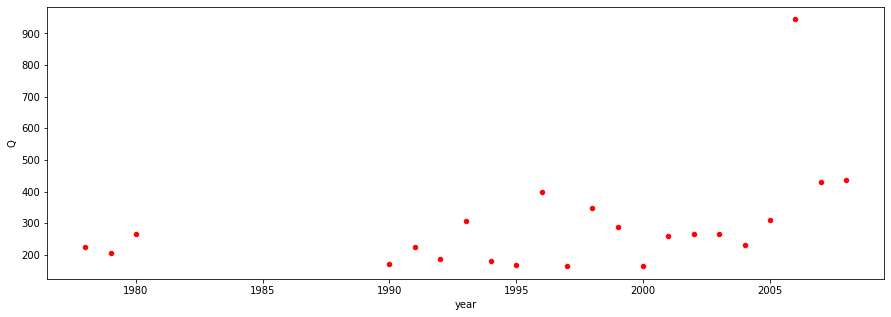

In [229]:
# Resample using the annual maximum value
df_ymax = df.resample("Y").max()
df_ymax["year"] = df_ymax.index.year
df_ymax.reset_index(inplace=True, drop=True)
df_ymax = df_ymax.dropna()
print(df_ymax)

# Manage plot
df_ymax.plot(kind='scatter',x='year',y='Q',color='red', figsize=(15,5))
plt.show()


### Return period analysis
We should compute the exceedence probability *Pr*, and the resulting recurrence interval.
Pr is defined as: $Pr_{i} = \frac{(n-i+1)}{n+1}$\
Where *n* is the total number of observation years and *i* is the rank of the event.

In [230]:
# Sort in increasing order

df_ymax_sorted = df_ymax.sort_values(by="Q")
n = df_ymax_sorted.shape[0]
df_ymax_sorted.insert(0, "rank", range(1, 1 + n))
print(df_ymax_sorted)


    rank   Time        Q  year
19     1  --:--  163.154  1997
22     2  --:--  164.060  2000
17     3  --:--  167.155  1995
12     4  --:--  169.851  1990
16     5  --:--  180.862  1994
14     6  --:--  186.504  1992
1      7  --:--  207.000  1979
0      8  --:--  224.000  1978
13     9  --:--  225.398  1991
26    10  --:--  230.376  2004
23    11  --:--  258.119  2001
24    12  --:--  264.301  2002
25    13  --:--  264.301  2003
2     14  --:--  266.000  1980
21    15  --:--  289.232  1999
15    16  --:--  307.421  1993
27    17  --:--  309.959  2005
20    18  --:--  347.518  1998
18    19  --:--  398.626  1996
29    20  --:--  430.396  2007
30    21  --:--  435.912  2008
28    22  --:--  944.125  2006


The **exceedence probability** ( *pr* ) can be calculated applying the formula:

In [231]:
df_ymax_sorted["pr"] = (n - df_ymax_sorted["rank"] + 1) / (n + 1)
print(df_ymax_sorted.tail())


    rank   Time        Q  year        pr
20    18  --:--  347.518  1998  0.217391
18    19  --:--  398.626  1996  0.173913
29    20  --:--  430.396  2007  0.130435
30    21  --:--  435.912  2008  0.086957
28    22  --:--  944.125  2006  0.043478


The **recurrence interval**( *return-period* ) is the inverse of the probability, thus:

In [225]:
df_ymax_sorted["return-period"] = 1 / df_ymax_sorted["pr"]
print(df_ymax_sorted.tail())


   rank   Time      Q  year    pr  return-period
1     1  --:--  588.0  1979  0.75       1.333333
0     2  --:--  794.0  1978  0.50       2.000000
2     3  --:--  824.0  1980  0.25       4.000000


Once create the table (*dataframe*) with all required information (**Probability** and **Return-Period**) we might plot it to visualise the recurrence interval of each observed discharge. It is worth mentioning that this analysis and the resulting plot refer only to observed values.<br>
To extrapolate recurrence interval beyond the observation period (the 1-in-100 years flood values, for instance) a prediction model is needed (Gumbel, GEV, etc..).

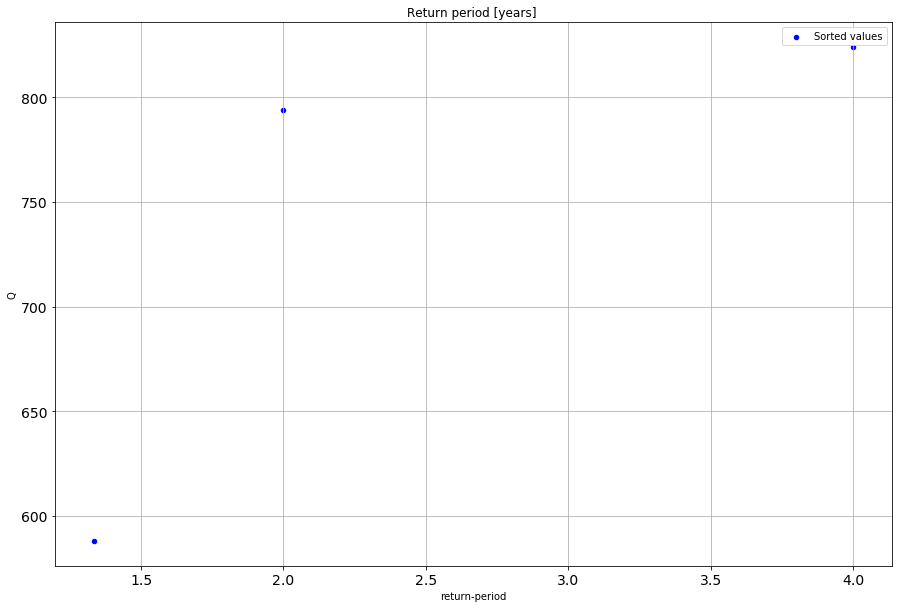

In [226]:
df_ymax_sorted.plot.scatter(y="Q",
                         x="return-period",
                         title="Return period [years] ",
                         color='blue',
                         grid=True,
                         fontsize=14,
                         logy=False,
                         label="Sorted values",
                         figsize=(15,10))


## That is for this brief practical introduction to Python! 
### You might exercise a bit:

* in the virtual environment you should find other discharge .txt files. Ask python to read and analyse your selected input file!
* which is the discharge value for Return Period = 5?
* which is the discharge value with a Probability of exceedance = 0.5?
* can you plot the return-periods in a logaritmic scale (for y)?